<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)

	<h1>入門機械学習による異常検出</h1>
	<p>
		井出　剛著の「入門機械学習による異常検出」(以降、井出本と記す)の例題をSageを使ってお復習いします。
	</p>
</html>

<html>
	<h2>2章　正規分布に従うデータからの異常検出</h2>
	<p>
		井出本の基本は、データに対するモデルを使って負の対数尤度を求め、それを異常検出関数として使うことです。
	</p>
	<h3>多変数正規分布に基づく異常検知</h3>
	<p>
		M次元、N個の観測データ$\mathcal{D}$が以下の様な多次元正規分布に従っていると、仮定します。
$$
	\mathcal{N}(x|\mu, \Sigma) = \frac{|\Sigma|^{-1/2}}{(2 \pi )^{M/2}} exp \left \{ -\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right \}
$$		
	</p>
	<p>
		対数尤度は、以下の様に計算されます。
$$
	L(\mu, \Sigma | \mathcal{D}) = ln \prod_{n=1}^{N} \mathcal{N} (x^{(n)} | \mu, \Sigma) = \sum_{n=1}^N ln \mathcal{N} (x^{(n)} | \mu, \Sigma)
$$		
	</p>
	<p>
		これに多次元正規分布$\mathcal{N}$の定義を代入すると、対数尤度Lは以下の様になります。
$$
	L(\mu, \Sigma | \mathcal{D}) = -\frac{M N}{2}ln(2 \pi) - \frac{N}{2} ln | \Sigma | 
		-\frac{1}{2} \sum_{n=1}^N (x^{(n)} - \mu)^T \Sigma^{-1} (x^{(n)} - \mu)
$$		
		
	</p>
	<p>
		これを$\mu, \Sigma$で偏微分して、尤度Lを最大にする$\mu, \Sigma$を求めます。
	</p>
	<p>
		最初にLを$\mu$で偏微分すると、以下の様になります。
$$
	\frac{\partial L(\mu, \Sigma | \mathcal{D})}{\partial \mu} = \sum_{n=1}^N \Sigma^{-1} (x^{(n)} - \mu)
$$		
	</p>
	<p>
		上記の式が0になる$\hat{\mu}$は以下の様に求まります。
$$
	\hat{\mu} = \frac{1}{N} \sum_{n=1}^N x^{(n)}
$$		
	</p>
	<p>
		次に、$\Sigma$での偏微分です。これには、以下の関係式を使います。
$$
	-ln | \Sigma | = ln | \Sigma^{-1} |
$$	
	と、
$$
	(x^{(n)} - \mu)^T \Sigma^{-1} (x^{(n)} - \mu) = Tr \left \{ \Sigma^{-1} (x^{(n)} - \mu) (x^{(n)} - \mu)^T \right \}
$$	
	と、以下の公式を使います。
$$
	\frac{\partial}{\partial A} Tr(A B) = \frac{\partial}{\partial A} Tr(B A) = B^T
$$	
$$
	\frac{\partial}{\partial A} ln |A| = (A^{-1})^T
$$
	</p>
	<p>
		偏微分の結果は、以下の様になります。共分散行列$\Sigma$が対象行列であるので、$\Sigma = \Sigma^T$を使っています。
$$
\begin{eqnarray}
	\frac{\partial L(\mu, \Sigma | \mathcal{D})}{\partial (\Sigma^{-1})} & = & \frac{N}{2}ln | \Sigma^{-1} |
		- \frac{1}{2} \Sigma^{-1} (x^{(n)} - \mu) (x^{(n)} - \mu)^T \\
		& = & \frac{N}{2} \Sigma^T - \frac{1}{2}\sum_{n=1}^N (x^{(n)} - \mu) (x^{(n)} - \mu)^T \\
		& = & \frac{N}{2} \Sigma - \frac{1}{2}\sum_{n=1}^N (x^{(n)} - \mu) (x^{(n)} - \mu)^T 
\end{eqnarray}		
$$		
	</p>
	<p>
		この値が０になるような$\hat{\Sigma}$は、以下の様に求まります。
$$
	\hat{\Sigma} = \frac{1}{N} \sum_{n=1}^N  (x^{(n)} - \mu) (x^{(n)} - \mu)^T 
$$		
	</p>
	<p>
		負の対数尤度を基に、異常度$a(x')$を以下の様に定義します。これは、マハラノビス距離と呼ばれ、「ばらつきが大きい方向の変動は大目にみる」効果があるそうです。
$$
	a(x') = ({x'} - \mu)^T \Sigma^{-1} ({x'} - \mu)
$$		
	</p>
	<p>
		しかし、実際のRでのプログラムをみると、ちょっと違っています。実行例2.5（Davisに対する異常度の計算部分）は、以下の計算をしています。
$$
	a(x') = \sum_{m=1}^M ({x'} - \mu)^2 \Sigma^{-1}
$$		
	</p>
	<p>
		値としては、Wikipediaにある共分散行列が対角行列であるときの以下の式に近いと思われます。
$$
	d(\vec{x}, \vec{y}) = \sqrt{\sum_{i=1}^P \frac{(x_i - y_i)^2}{\sigma_i^2}}
$$		
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。jupyter用に新しくなったRUtil.pyも使います。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>データを使って異常度を計算する</h2>
	<p>
		Rのcarパッケージに入っているデータDavisを使って、多次元データの異常度を求めてみましょう。
	</p>
</html>

In [3]:
# 2.2 carパッケージのDavisを使って例題を試す
# carパッケージのインストールには、時間が掛かりますので注意してください。
r('library(car)')

 [1] "car"       "jsonlite"  "ggplot2"   "stats"     "graphics"  "grDevices" "utils"     "datasets" 
 [9] "methods"   "base"     

<html>
	<h3>データの性格を知る</h3>
	<p>
		Rのデータをpandaのデータフレームに変換して、データの性格を調べます。
		最初にinfoとdescribeで個数や欠損値、平均、分散などの統計情報を求めます。
	</p>
</html>

In [5]:
# Rのデータをpandaのデータフレームに変換する
davis = RDf2PandaDf("Davis")
# データの個数と欠損値の有無をみる
davis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
height    200 non-null int64
repht     183 non-null float64
repwt     183 non-null float64
sex       200 non-null object
weight    200 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.4+ KB


In [7]:
# データの情報を取り出す
davis.describe()

,height,repht,repwt,weight
count,200.000000,183.000000,183.000000,200.000000
mean,170.020000,168.497268,65.622951,65.800000
std,12.007937,9.467048,13.776669,15.095009
min,57.000000,148.000000,41.000000,39.000000
25%,164.000000,NaN,NaN,55.000000
50%,169.500000,NaN,NaN,63.000000
75%,177.250000,NaN,NaN,74.000000
max,197.000000,200.000000,124.000000,166.000000


<html>
	<p>
		次にDavisの体重のヒストグラムと体重（weight）と身長（height）の散布図をプロットし、おおざっぱな性質を調べます。
	</p>
</html>


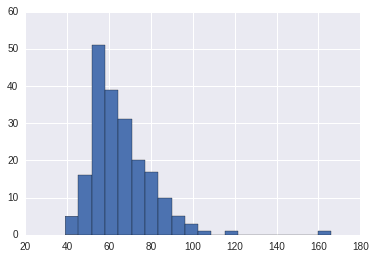

In [10]:
# weightの分布をみる
davis.weight.hist(bins=20)
plt.show()

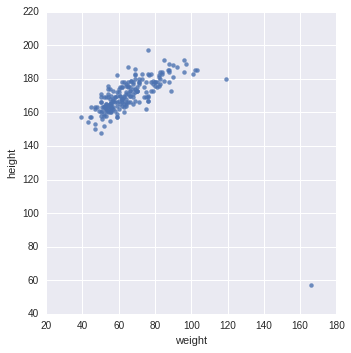

In [12]:
# 身長（height）と体重（weight）の関係をみる
sns.lmplot('weight', 'height', data=davis, fit_reg=False )
plt.show()

<html>
	<h3>Sageとpandasの機能を使って共分散行列を求める</h3>
	<p>
		Sageとpandas(numpy)の機能を使って共分散を求めみましょう。
	</p>
	<p>
		平均mxを求めてデータの平均からの差Xcを求めます。pandasではこれらをmeanとマイナス記号で処理することができます。
	</p>
	<p>
		数式では共分散行列$\hat{\Sigma}$は、以下の様に定義されていますが、
$$
	\hat{\mu} = \frac{1}{N}\sum_{n=1}^N x^{(n)}, 
	\hat{\Sigma} = \frac{1}{N} \sum_{n=1}^N (x^{(n)} - \hat{\mu})(x^{(n)} - \hat{\mu})^T
$$		
	Xcが列ベクトルではなく、行ベクトルなので、以下の様に計算しています。
$$
	\hat{\Sigma} = \frac{1}{N} Xc^T Xc
$$		
	</p>
</html>

In [13]:
# pandaデータフレームで、weightとheightの平均からのずれXcを計算する
X = davis[['weight', 'height']]
mx = X.mean()
Xc = X - mx

<html>
	<p>
		numpyの固有の理由だと思いますが、マトリックスの積に.dot()関数を使います。この辺はちょっと違和感があります。
	</p>
	<p>
		Pnadasの機能を使うと共分散行列は一発で計算できるのですが欠損値の影響なのか値が一致しません。
	</p>
</html>

In [15]:
# Pandaで標本共分散行列を求めるには
print Xc.T.dot(Xc) /len(Xc)
# もっと簡単なのはcov関数を使う（でも値が微妙に異なるのは、欠損値があるからか？）
print Xc.cov()

         weight    height
weight  226.720   34.2040
height   34.204  143.4696
            weight      height
weight  227.859296   34.375879
height   34.375879  144.190553


<html>
	<h3>Sageのマトリックスを使った異常度の計算</h3>
	<p>
		Sageのmatrixを使った異常度の計算方法を以下に示します。
	</p>
	<p>
		理論をベースとしているSageと実験値を処理するためのPandas, 
		numpyをどうやって融合するのかがSage使いの腕の見せ所です。
	</p>
	<p>
		と言ってもやっていることは簡単です。マトリックスの要素単位の処理をするには、
		Sageのmatrixにnumpy()メソッドで、numpyのマトリックスに変換するだけです。		
	</p>
	<p>
		Rやnumpyでは多くのデータを一括して処理することが多く、要素単位の処理に四則演算子が
		使われますが、Sageではマトリックスやベクトルの定義に沿って計算が行われます。
	</p>
</html>

In [16]:
# Sageのmatrixを使った計算
# 中心化したデータをSageのマトリックスにする
Xc =matrix((X - mx).values)

In [17]:
# 標本共分散行列を求める
Sx = Xc.T*Xc/ Xc.nrows(); Sx

[ 226.7199999999998 34.203999999999986]
[34.203999999999986  143.4696000000001]

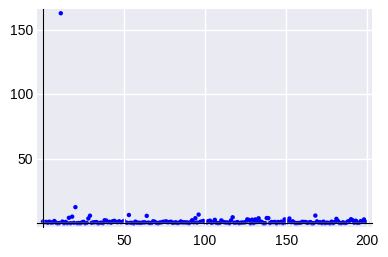

In [19]:
# (XcとSxの逆行列の積)の各要素とXcの各要素を掛け合わせる
# ここでのトリックは、numpyの*が要素毎の積であることを利用
# numpy()関数を使ってマトリックスをnumpyのマトリックスに変換する
a_prev = (Xc*Sx.inverse()).numpy() * Xc.numpy()
# 行単位の和を求める
a = [sum(x) for x in a_prev]
# リストプロット
list_plot(a, figsize=4)

<html>
	<h3>Pandaを使った異常度の計算</h3>
	<p>
		pandaとnumpyの機能を使って異常値を計算します。ここでは、$\Sigma^{-1} Xc$がsolveの解であることを
		使っています。また、次数の和には、pythonのsumを使っています。
	</p>
	<p>
		出力結果では、１つだけ突出した異常データが見つかります。
	</p>
	<p>
		全体的な処理から以降ではPandaを使った分散行列の方式を使います。
	</p>
</html>

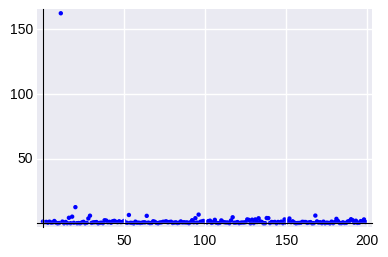

In [21]:
# Pandaのみを使った計算
# 中心化したデータの値をXcにセット
Xc =(X - mx).values
# 標本共分散行列を求める
Sx = (X - mx).cov().values
# 異常値aを求めるΣ^-1 * Xcは、solveの解を利用
a_prev = np.linalg.solve(Sx, Xc.T).T * Xc
# 行単位の和を求める
a = [sum(x) for x in a_prev]
# リストプロット
list_plot(a, figsize=4)

<html>
	<h2>マハラノビス=タグチ法</h2>
	<p>
		異常値の検出では、全体に対する個々の観測値の異常を検出するのに使用しましたが、
		個々の観測値の変数値の異常を検出するには、マハラノビス=タグチ法を使用します。
	</p>
	<p>
		M変数のなかからいくつかの変数を選び、1変数当たりの異常度を以下の様に検出します。
		
$$
	SN_q = -10 log_{10} \left \{ \frac{1}{N'} \sum_{n=1}^{N'} \frac{1}{a_q(x'^{(n)})/M_q} \right \}
$$		
	</p>
	<h3>MASSパッケージのroadデータで実験</h3>
	<p>
		マハラノビス=タグチ法の実行例2.6をSageを使って試してみましょう。
	</p>
	<p>
		MASSパッケージのroadデータには、アメリカ２６州の交通事故死亡者数deaths、運転者数drivers、
		人口密度popden、郊外地区の道路長rural、1月における1日の最高気温の平均値temp、1年度との燃料消費量
		fuelの６変数を記録しています。
	</p>
	<p>
		データの前段階でroadをdriversで割って対数化する必要があるのですが、pandaで処理する方法が見つからず、
		Rで前処理することにしました（残念）。
	</p>
	<p>
		取り込んだデータは、infoで個数と欠損値の有無を調べ、内容を調べます。
		$rowという変な名前が存在するので、stateに置き替えます。
	</p>
</html>

In [23]:
# マハラノビス=タグチ法
# MASSパッケージのroadデータを使って計算
r('library(MASS)')
# roadをPandaのデータフレームに変換
# road / road$driversとlogを使った対数化がPandaで処理する方法がみつからない
r('X <- road / road$drivers')
r('X <-log(X[, -2] + 1)')
road = RDf2PandaDf("X")
road.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Data columns (total 6 columns):
_row      26 non-null object
deaths    26 non-null float64
fuel      26 non-null float64
popden    26 non-null float64
rural     26 non-null float64
temp      26 non-null float64
dtypes: float64(5), object(1)
memory usage: 1.4+ KB


In [24]:
# _rowという変な名前が存在するので、headで内容をチェック、_rowが州の名前だと判明
road.head()

,_row,deaths,fuel,popden,rural,temp
0,Alabama,1.9638,0.5614,0.3401,0.3491,0.3310
1,Alaska,1.5911,0.4470,0.0357,0.4294,1.3157
2,Arizona,2.0098,0.5390,0.1239,0.3094,0.5326
3,Arkanas,2.0740,0.5902,0.3145,0.5842,0.4411
4,Calif,1.7888,0.1046,0.0999,0.1168,0.0660


In [25]:
# 州のカラムにstateをセットする
road.columns = ['state', 'deaths',  'fuel',  'popden',  'rural',  'temp']
# Calif州のデータをピックアップする
road[road.state == 'Calif']

,state,deaths,fuel,popden,rural,temp
4,Calif,1.7888,0.1046,0.0999,0.1168,0.066


<html>
	<h3>1変数当たりの異常度とCalifのSN比を求める</h3>
	<p>
		異常度の計算と同様に異常度を求め、次元数で割って1変数当たりの異常度を求めます。
	</p>
</html>

In [26]:
# pandaデータフレームで、平均からのずれXcを計算する
X = road[['deaths',  'fuel',  'popden',  'rural',  'temp']]
mx = X.mean()
Xc = X - mx
Xc.shape[1]

5

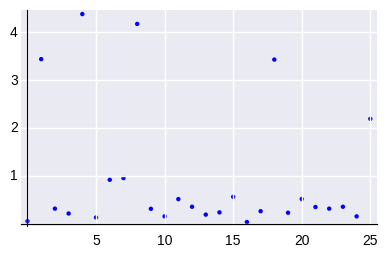

In [27]:
# Pandaのみを使った計算
# 中心化したデータをnumpyのマトリックスにする
Xc =(X - mx).values
# 標本共分散行列を求める
Sx = (X - mx).cov().values
# 異常値aを求めるΣ^-1 * Xcは、solveの解を利用
a_prev = np.linalg.solve(Sx, Xc.T).T * Xc
# 行単位の和を求め、１変数当たりの異常度を計算する
a = [sum(x)/Xc.shape[1] for x in a_prev]
# リストプロット
list_plot(a, figsize=4)

<html>
	<p>
		最も異常度の大きい、CalifのデータをXcから取り出し、SN比を計算し、棒グラフで表示します。		
	</p>
	<p>
		表示順はdeaths  fuel  popden  rural  tempで、図2.7(b)と並びが異なりますが、
		値は同じ結果になっています。
	</p>
	<p>
		この結果から、異常に寄与している変数は、通事故死亡者数deaths、1年度との燃料消費量
		fuel、人口密度popdenであることが分かります。
		この結果は、車が多く使用される過密な大都市で交通事故死亡者が増加するという一般的な
		常識と一致します。
	</p>
</html>

In [28]:
# XcからCalifのデータを取得
Xc_prime = Xc[4]
# 要素毎の計算をしたいので、numpyの形式に変換
SN1 = 10*np.log10(Xc_prime^2/Sx.diagonal())
print SN1

[-14.80328085  12.82597259  -6.26565335  -0.20576912   0.21784965]


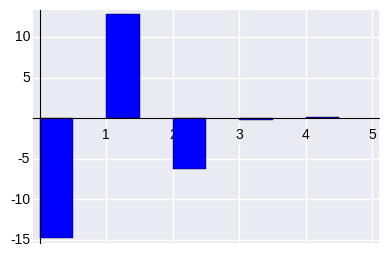

In [29]:
# 左からdeaths  fuel  popden  rural  tempで、図2.7(b)と並びが異なる
bar_chart(SN1, figsize=4)